In [4]:
import sys
import random
import os
import numpy as np
import iisignature as iis
import matplotlib.pyplot as plt
import gudhi
from gudhi import plot_persistence_diagram
from gudhi import plot_persistence_density
from gtda.homology import VietorisRipsPersistence
from gtda.homology import FlagserPersistence
from gtda.diagrams import PersistenceEntropy
from gtda.diagrams import Amplitude
from gudhi.representations.vector_methods import Entropy
from gtda.diagrams import PairwiseDistance
from gtda.plotting import plot_diagram
import numpy.random as rd
import gudhi.representations
import random
from scipy.stats import zscore
%run FUNCTIONS.ipynb

In [5]:
def logistic(r, x):
    return (1 - r * (x**2))
    # alternative  chaotic map
    # return(4*x*(1-x))


# See book of Kaneko for parameters of eps and/or r to have different regimes
# or https://en.wikipedia.org/wiki/Coupled_map_lattice for notable regimes


# Generate couple map lattice according to this equation: x_i^t= (1-\eps)f[x_i^{t-1}] + \eps/order \sum_{j in \neighbours} f[x_j]^{t-1}
def generate_couple_map(T, N, epsilon, transient_time, r, order=2):
    series = {}

    # Filing the dictionary with N initial random values
    for index_series in range(0, N):
        s = random.random()
        series[index_series] = [s]

    # Generate the coupled maps for a length of size T (yet, we discard the first transient_time elements to remove the transient)
    for i in range(1, T + transient_time + 1):
        for index_series in range(0, N):
            order_k_term = compute_neighbours(N, series, epsilon, index_series, i - 1, r, order)
            new_point = (1 - epsilon) * logistic(r,series[index_series][i - 1]) + order_k_term
            series[index_series].append(new_point)
    return(series)



def compute_neighbours(N, series, epsilon, index_series, i, r, order=2):
    eps_overN = epsilon * (1 / order)
    term_left_right = int(order / 2)

    term = 0
    # Sum over the left neighbors with periodic boundary conditions
    for s in range(1, term_left_right + 1):
        term += logistic(r, series[(index_series - s) % N][i])

    # Sum over the right neighbors with periodic boundary conditions
    for s in range(1, term_left_right + 1):
        term += logistic(r, series[(index_series + s) % N][i])

    # if order is odd, then take the neighbors in an asymmetric way, int(order/2) on the left, int(order/2)+1 on the right
    if order % 2 == 1:
        s = term_left_right + 1
        term += logistic(r, series[(index_series + s) % N][i])

    return(term * eps_overN)

In [6]:
def en_1_vector(time_series,length):
    l=time_series.shape[0]
    N=time_series.shape[1]
    h=np.modf(l/length)[1]
    en_1_ts=[]
    for i in range(1,length+1):
        sub_ts=time_series[:np.int64(h)*i,:]
        L=lead_matrix_1(sub_ts)
        dgm_clique=rev_undirected(L)
        PE = PersistenceEntropy()
        pe_feat = PE.fit_transform(dgm_clique)
        en_1_ts.append(pe_feat[0,1])
    return en_1_ts


def am_1_vector(time_series,length):
    l=time_series.shape[0]
    N=time_series.shape[1]
    h=np.modf(l/length)[1]
    am_1_ts=[]
    for i in range(1,length+1):
        sub_ts=time_series[:np.int64(h)*i,:]
        L=lead_matrix_1(sub_ts)
        dgm_clique=rev_undirected(L)
        A=Amplitude()
        ampl_feat=A.fit_transform(dgm_clique)
        am_1_ts.append(ampl_feat[0,1])
    return am_1_ts



def en_h_hyp_v(time_series,length,indifference_value):
    l=time_series.shape[0]
    N=time_series.shape[1]
    h=np.modf(l/length)[1]
    en_0_ts=[]
    en_1_ts=[]
    hyp_ts=[]
    for i in range(1,length+1):
        sub_ts=time_series[:np.int64(h)*i,:]
        dgm,hyp=create_diagram_directly_3(sub_ts,indifference_value)
        S_0,S_1=entropy_gu_ad(dgm)
        en_1_ts.append(S_1)
        hyp_ts.append(hyp)
        en_0_ts.append(S_0)
    return hyp_ts, en_1_ts, en_0_ts

In [18]:
def violating_momentum(L,T,indifference_value):
    N=L.shape[0]
    total=0
    violating_momentum=0
    for i in range(N):
        for j in range(i,N):
            for k in range(j,N):
                if ((not (j==i)) and (not (i==k)) and (not (j==k))):
                    total=total+1
                    a=np.abs(L[i,j]+L[j,k]+L[k,i])
                    b=np.abs(T[i,j,k])
                    if np.abs(a-b)<indifference_value:
                        a=b
                    if b>a:
                        violating_momentum=violating_momentum+1
    viol=violating_momentum/total
    return viol


def viol_ts(time_series,indifference_value):
    L=lead_matrix_1(time_series)
    T=lead_tensor_1(time_series)
    viol=violating_momentum(L,T,indifference_value)
    return viol

def viol_v(time_series,length,indifference_value):
    viol_v=[]
    l=time_series.shape[0]
    N=time_series.shape[1]
    h=np.modf(l/length)[1]
    for i in range(1,length+1):
        sub_ts=time_series[:(np.int64(h)*i),:]
        viol=viol_ts(sub_ts,indifference_value)
        viol_v.append(viol)
    return viol_v
    

In [8]:
data_PS=generate_couple_map(20000,100,0.4, 1, 1.71, order=2)
ts_PS=np.zeros((401,100))
for j in range(100):
    ts_PS[:,j]=data_PS[j][10000::25]
    
    
data_CBMD=generate_couple_map(20000,100,0.1, 1, 1.85, order=2)
ts_CBMD=np.zeros((401,100))
for j in range(100):
    ts_CBMD[:,j]=data_CBMD[j][10000::25]
    
data_FDC=generate_couple_map(20000,100,0.3, 1, 2.00, order=2)
ts_FDC=np.zeros((401,100))
for j in range(100):
    ts_FDC[:,j]=data_FDC[j][10000::25]
    
data_STI=generate_couple_map(20000,100,0.6, 1, 1.75, order=2)
ts_STI=np.zeros((401,100))
for j in range(100):
    ts_STI[:,j]=data_STI[j][10000::25]
    
    
data_DT=generate_couple_map(20000,100,0.1, 1, 1.895, order=2)
ts_DT=np.zeros((401,100))
for j in range(100):
    ts_DT[:,j]=data_DT[j][10000::25]

In [103]:
length=150

In [104]:
# Clique complex
# Entropy  curves

#no zscore
en_PS=en_1_vector(ts_PS,length) 
en_DT=en_1_vector(ts_DT,length)    
en_STI=en_1_vector(ts_STI,length)
en_FDC=en_1_vector(ts_FDC,length)
en_CBMD=en_1_vector(ts_CBMD,length)

# Z score
ts_PS_z=zscore(ts_PS,axis=0)
en_PS_z=en_1_vector(ts_PS_z,length) 
ts_DT_z=zscore(ts_DT,axis=0)
en_DT_z=en_1_vector(ts_DT_z,length)    
ts_STI_z=zscore(ts_STI,axis=0)
en_STI_z=en_1_vector(ts_STI_z,length)
ts_FDC_z=zscore(ts_FDC,axis=0)
en_FDC_z=en_1_vector(ts_FDC_z,length)
ts_CBMD_z=zscore(ts_CBMD,axis=0)
en_CBMD_z=en_1_vector(ts_CBMD_z,length)

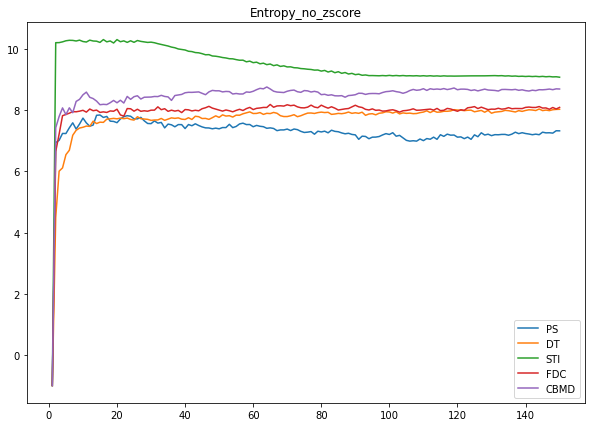

In [105]:
# Plot entropy no z score
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Entropy_no_zscore")
plt.plot(x,en_PS)
plt.plot(x,en_DT)
plt.plot(x,en_STI)
plt.plot(x,en_FDC)
plt.plot(x,en_CBMD)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Entropy_no_z_score.png")
plt.show()

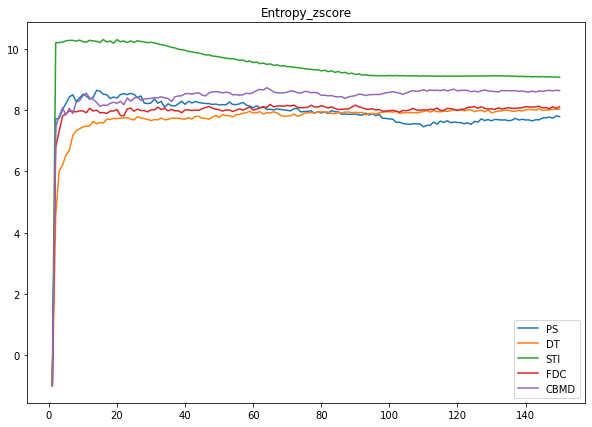

In [117]:
# Plot entropy z score
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Entropy_zscore")
plt.plot(x,en_PS_z)
plt.plot(x,en_DT_z)
plt.plot(x,en_STI_z)
plt.plot(x,en_FDC_z)
plt.plot(x,en_CBMD_z)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Entropy_z_score.png")
plt.show()

In [107]:
# Amplitude  curves

#no zscore
am_PS=am_1_vector(ts_PS,length) 
am_DT=am_1_vector(ts_DT,length)   
am_STI=am_1_vector(ts_STI,length)
am_FDC=am_1_vector(ts_FDC,length)
am_CBMD=am_1_vector(ts_CBMD,length)

# z score
ts_PS_z=zscore(ts_PS,axis=0)
am_PS_z=am_1_vector(ts_PS_z,length) 
ts_DT_z=zscore(ts_DT,axis=0)
am_DT_z=am_1_vector(ts_DT_z,length)    
ts_STI_z=zscore(ts_STI,axis=0)
am_STI_z=am_1_vector(ts_STI_z,length)
ts_FDC_z=zscore(ts_FDC,axis=0)
am_FDC_z=am_1_vector(ts_FDC_z,length)
ts_CBMD_z=zscore(ts_CBMD,axis=0)
am_CBMD_z=am_1_vector(ts_CBMD_z,length)

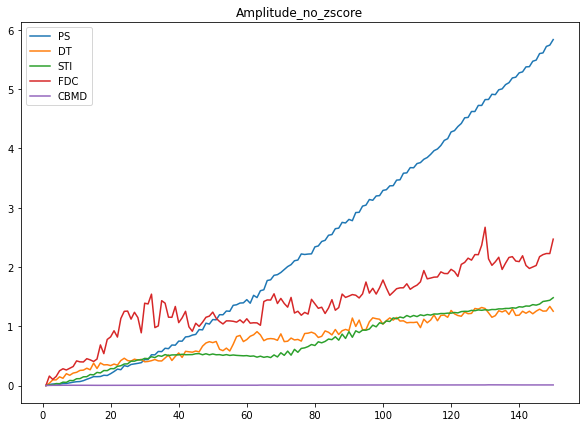

In [108]:
# Plot  amplitude no z score
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Amplitude_no_zscore")
plt.plot(x,am_PS)
plt.plot(x,am_DT)
plt.plot(x,am_STI)
plt.plot(x,am_FDC)
plt.plot(x,am_CBMD)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Amplitude_no_z_score.png")
plt.show()

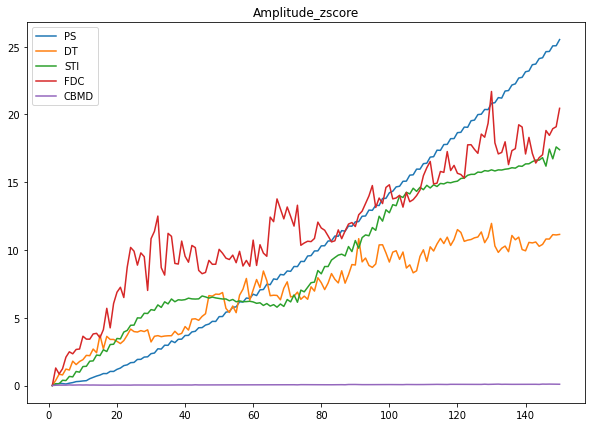

In [109]:
# Plot amplitude z score
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Amplitude_zscore")
plt.plot(x,am_PS_z)
plt.plot(x,am_DT_z)
plt.plot(x,am_STI_z)
plt.plot(x,am_FDC_z)
plt.plot(x,am_CBMD_z)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Amplitude_z_score.png")
plt.show()

In [94]:
# Entropy high order


length=120
indifference_value=0.05

#no zscore
hyp_PS,en_1_PS,en_0_PS=en_h_hyp_v(ts_PS,length,indifference_value) 
hyp_DT,en_1_DT,en_0_DT=en_h_hyp_v(ts_DT,length,indifference_value)   
hyp_STI,en_1_STI,en_0_STI=en_h_hyp_v(ts_STI,length,indifference_value)
hyp_FDC,en_1_FDC,en_0_FDC=en_h_hyp_v(ts_FDC,length,indifference_value)
hyp_CBMD,en_1_CBMD,en_0_CBMD=en_h_hyp_v(ts_CBMD,length,indifference_value)

# z score
ts_PS_z=zscore(ts_PS,axis=0)
hyp_PS_z,en_1_PS_z,en_0_PS_z=en_h_hyp_v(ts_PS_z,length,indifference_value) 
ts_DT_z=zscore(ts_DT,axis=0)
hyp_DT_z,en_1_DT_z,en_0_DT_z=en_h_hyp_v(ts_DT_z,length,indifference_value)    
ts_STI_z=zscore(ts_STI,axis=0)
hyp_STI_z,en_1_STI_z,en_0_STI_z=en_h_hyp_v(ts_STI_z,length,indifference_value)
ts_FDC_z=zscore(ts_FDC,axis=0)
hyp_FDC_z,en_1_FDC_z,en_0_FDC_z=en_h_hyp_v(ts_FDC_z,length,indifference_value)
ts_CBMD_z=zscore(ts_CBMD,axis=0)
hyp_CBMD_z,en_1_CBMD_z,en_0_CBMD_z=en_h_hyp_v(ts_CBMD_z,length,indifference_value)

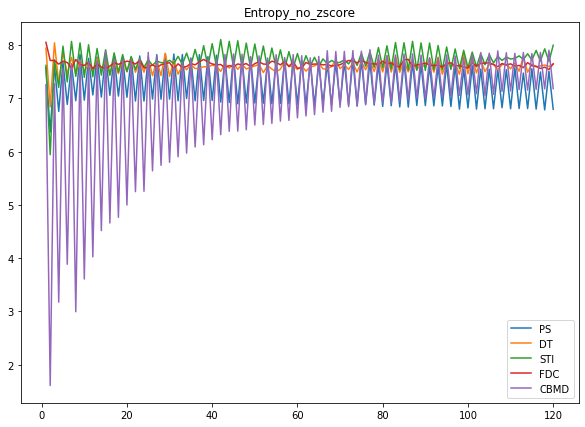

In [116]:
# Plot entropy high 1 no z score
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Entropy_no_zscore")
plt.plot(x,en_1_PS)
plt.plot(x,en_1_DT)
plt.plot(x,en_1_STI)
plt.plot(x,en_1_FDC)
plt.plot(x,en_1_CBMD)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Entropy_high_no_z_score.png")
plt.show()

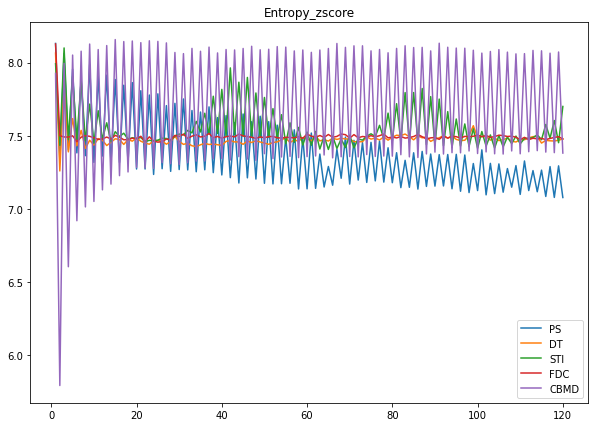

In [115]:
# Plot entropy 1 high z score
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Entropy_zscore")
plt.plot(x,en_1_PS_z)
plt.plot(x,en_1_DT_z)
plt.plot(x,en_1_STI_z)
plt.plot(x,en_1_FDC_z)
plt.plot(x,en_1_CBMD_z)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Entropy_high_z_score.png")
plt.show()

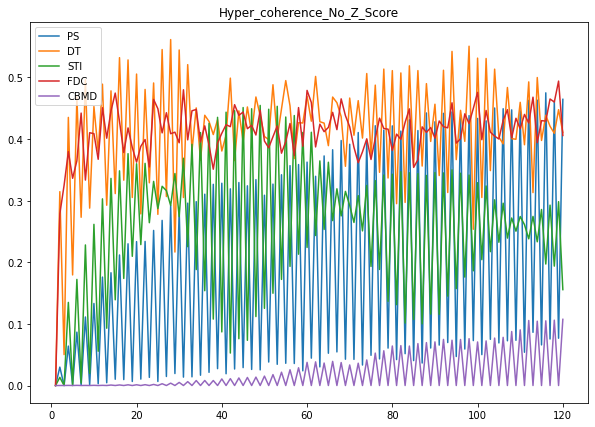

In [111]:
# plot hyper coherence no z score
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Hyper_coherence_No_Z_Score")
plt.plot(x,hyp_PS)
plt.plot(x,hyp_DT)
plt.plot(x,hyp_STI)
plt.plot(x,hyp_FDC)
plt.plot(x,hyp_CBMD)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Hyperocherence_no_zscore.png")
plt.show()

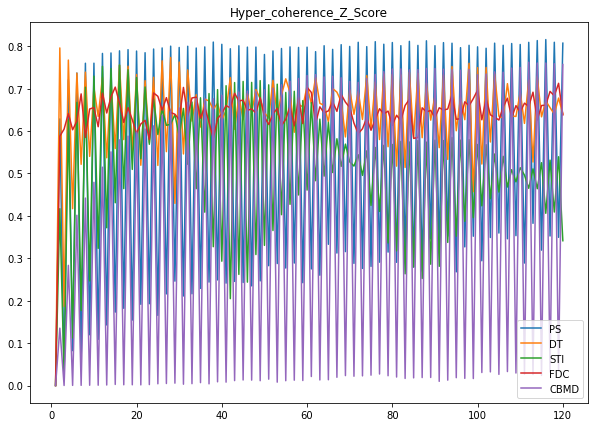

In [112]:
# plot hyper coherence zscore
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Hyper_coherence_Z_Score")
plt.plot(x,hyp_PS_z)
plt.plot(x,hyp_DT_z)
plt.plot(x,hyp_STI_z)
plt.plot(x,hyp_FDC_z)
plt.plot(x,hyp_CBMD_z)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Hyperocherence_Z_Score.png")
plt.show()

In [19]:
# parameters
length=100
indifference_value=0.05

#no zscore
viol_PS=viol_v(ts_PS,length,indifference_value) 
viol_DT=viol_v(ts_DT,length,indifference_value)   
viol_STI=viol_v(ts_STI,length,indifference_value)
viol_FDC=viol_v(ts_FDC,length,indifference_value)
viol_CBMD=viol_v(ts_CBMD,length,indifference_value)

# z score
ts_PS_z=zscore(ts_PS,axis=0)
viol_PS_z=viol_v(ts_PS_z,length,indifference_value) 
ts_DT_z=zscore(ts_DT,axis=0)
viol_DT_z=viol_v(ts_DT_z,length,indifference_value)    
ts_STI_z=zscore(ts_STI,axis=0)
viol_STI_z=viol_v(ts_STI_z,length,indifference_value)
ts_FDC_z=zscore(ts_FDC,axis=0)
viol_FDC_z=viol_v(ts_FDC_z,length,indifference_value)
ts_CBMD_z=zscore(ts_CBMD,axis=0)
viol_CBMD_z=viol_v(ts_CBMD_z,length,indifference_value)



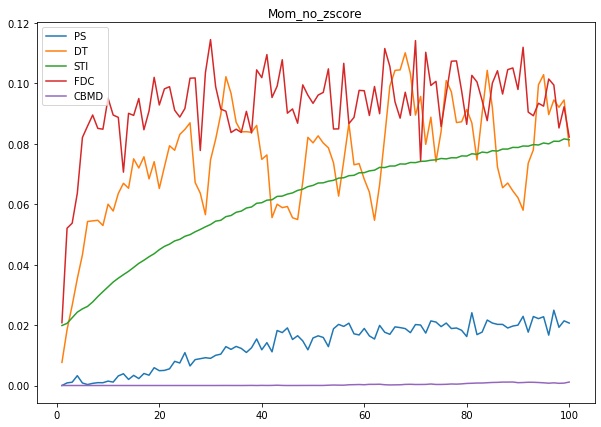

In [22]:
# Plot entropy high 1 no z score
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Mom_no_zscore")
plt.plot(x,viol_PS)
plt.plot(x,viol_DT)
plt.plot(x,viol_STI)
plt.plot(x,viol_FDC)
plt.plot(x,viol_CBMD)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Mom_high_no_z_score.png")
plt.show()

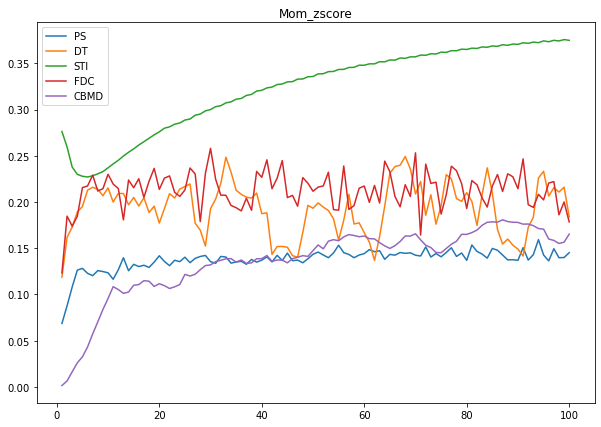

In [23]:
# Plot entropy high 1 no z score
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Mom_zscore")
plt.plot(x,viol_PS_z)
plt.plot(x,viol_DT_z)
plt.plot(x,viol_STI_z)
plt.plot(x,viol_FDC_z)
plt.plot(x,viol_CBMD_z)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Mom_zscore.png")
plt.show()